In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import nibabel as nib
import numpy as np
import os
import os.path as op

from glob import glob
from nilearn import plotting

/Users/richford/miniconda3/envs/nobrainer/lib/python3.8/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [6]:
nifti_dir = "../data/osfstorage/deep-learning-qc/integrated-gradients"
confusion_classes = ["true_pos", "true_neg", "false_pos", "false_neg"]
channel2label_map = {
    "b0": "b0",
    "x": "color_fa",
    "y": "color_fa",
    "z": "color_fa",
    "fa_norm": "color_fa",
    "fa_sum": "color_fa",
}

def attribution_diff(fn_pass, channel=None):
    pass_vol = nib.load(fn_pass)
    
    affine = pass_vol.affine
    diff = pass_vol.get_fdata()
    
    channel_idx = {
        "x": 0,
        "y": 1,
        "z": 2,
    }
    
    if channel in channel_idx.keys():
        diff = diff[:, :, :, channel_idx[channel]]
    if channel == "fa_norm":
        diff = np.linalg.norm(diff, axis=-1)
    if channel == "fa_sum":
        diff = np.sum(diff, axis=-1)

    return nib.Nifti1Image(diff, affine)
        
    
attribution_maps = {
    conf_class: [
        {
            channel: attribution_diff(
                fn_pass=op.join(nifti_dir, f"{conf_class}_attribution_pass_{label}_{idx}.nii.gz"),
                channel=channel,
            )
            for channel, label in channel2label_map.items()
        }
        for idx in range(3)
    ]
    for conf_class in confusion_classes
}

In [7]:
def get_bg_volume(fname, channel):
    nifti = nib.load(fname)
    affine = nifti.affine
    volume = nifti.get_fdata()
    
    channel_idx = {
        "x": 0,
        "y": 1,
        "z": 2,
    }

    if channel in channel_idx.keys():
        volume = volume[:, :, :, channel_idx[channel]]
    if channel == "fa_norm":
        volume = np.linalg.norm(volume, axis=-1)
    if channel == "fa_sum":
        volume = np.sum(volume, axis=-1)
    
    return nib.Nifti1Image(volume, affine)
    
bg_volumes = {
    conf_class: [
        {
            channel: get_bg_volume(
                fname=op.join(nifti_dir, f"{conf_class}_{label}_{idx}.nii.gz"),
                channel=channel,
            )
            for channel, label in channel2label_map.items()
        }
        for idx in range(3)
    ]
    for conf_class in confusion_classes
}

In [82]:
def plot_bg(volumes,
            conf_class,
            channel="b0",
            subject_slice=slice(None),
            cut_coords=np.arange(46, 74, 6),
            display_mode="z",
            title=None):
    title = title or "_".join([conf_class, channel]).replace("_", " ")
    
    return [
        plotting.plot_anat(
            anat_img=channel_dict[channel],
            cut_coords=cut_coords,
            display_mode=display_mode,
            title=title,
        )
        for channel_dict in volumes[conf_class][subject_slice]
    ]


def plot_attribution(attribution_volumes,
                     bg_volumes,
                     conf_class,
                     channel="b0",
                     subject_idx=0,
                     cut_coords=np.arange(46, 74, 6),
                     display_mode="z",
                     threshold=None,
                     title=None,
                     arcsinh_transform=False,
                     cmap=None,
                     axes=None,
                     colorbar=True,
                     annotate=True,
                     dim="auto"):
    if title == "auto":
        title = "_".join([conf_class, channel]).replace("_", " ")
    
    def transform(img):
        if arcsinh_transform:
            x = img.get_fdata()
            return nib.Nifti1Image(np.arcsinh(5e5 * x) / 5.5, img.affine)
        else:
            return img
    
    def get_threshold(img, percentile):
        if percentile is None:
            thresh = None
        else:
            thresh = np.nanpercentile(np.abs(img.get_fdata()), percentile)
            
        return thresh
    
    kwargs = dict(
        cut_coords=cut_coords,
        display_mode=display_mode,
        title=title,
        axes=axes,
        colorbar=colorbar,
        annotate=annotate,
        dim=dim,
    )
    
    if cmap is not None:
        kwargs["cmap"] = cmap
    
    ig_dict = attribution_volumes[conf_class][subject_idx]
    bg_dict = bg_volumes[conf_class][subject_idx]
    
    return plotting.plot_stat_map(
        stat_map_img=transform(ig_dict[channel]),
        bg_img=bg_dict.get(channel, bg_dict["b0"]),
        threshold=get_threshold(transform(ig_dict[channel]), threshold),
        **kwargs
    )

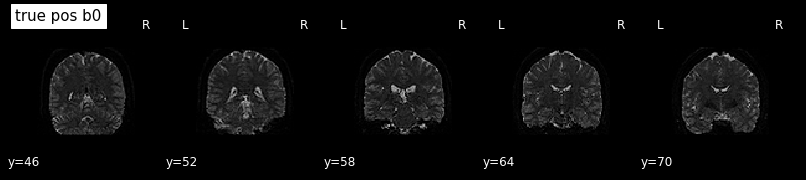

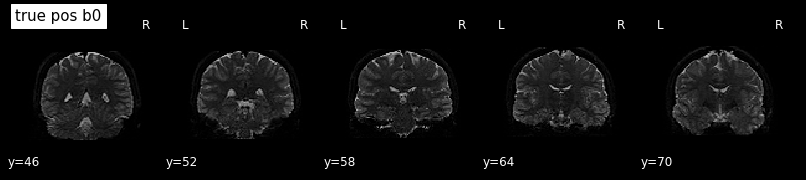

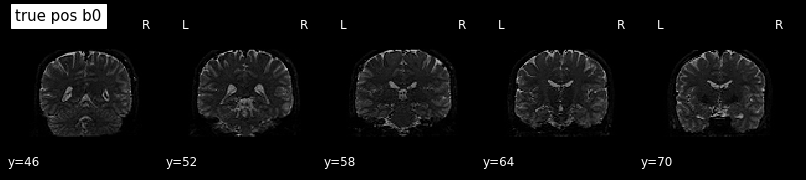

In [101]:
_ = plot_bg(bg_volumes, conf_class="true_pos", display_mode="y")

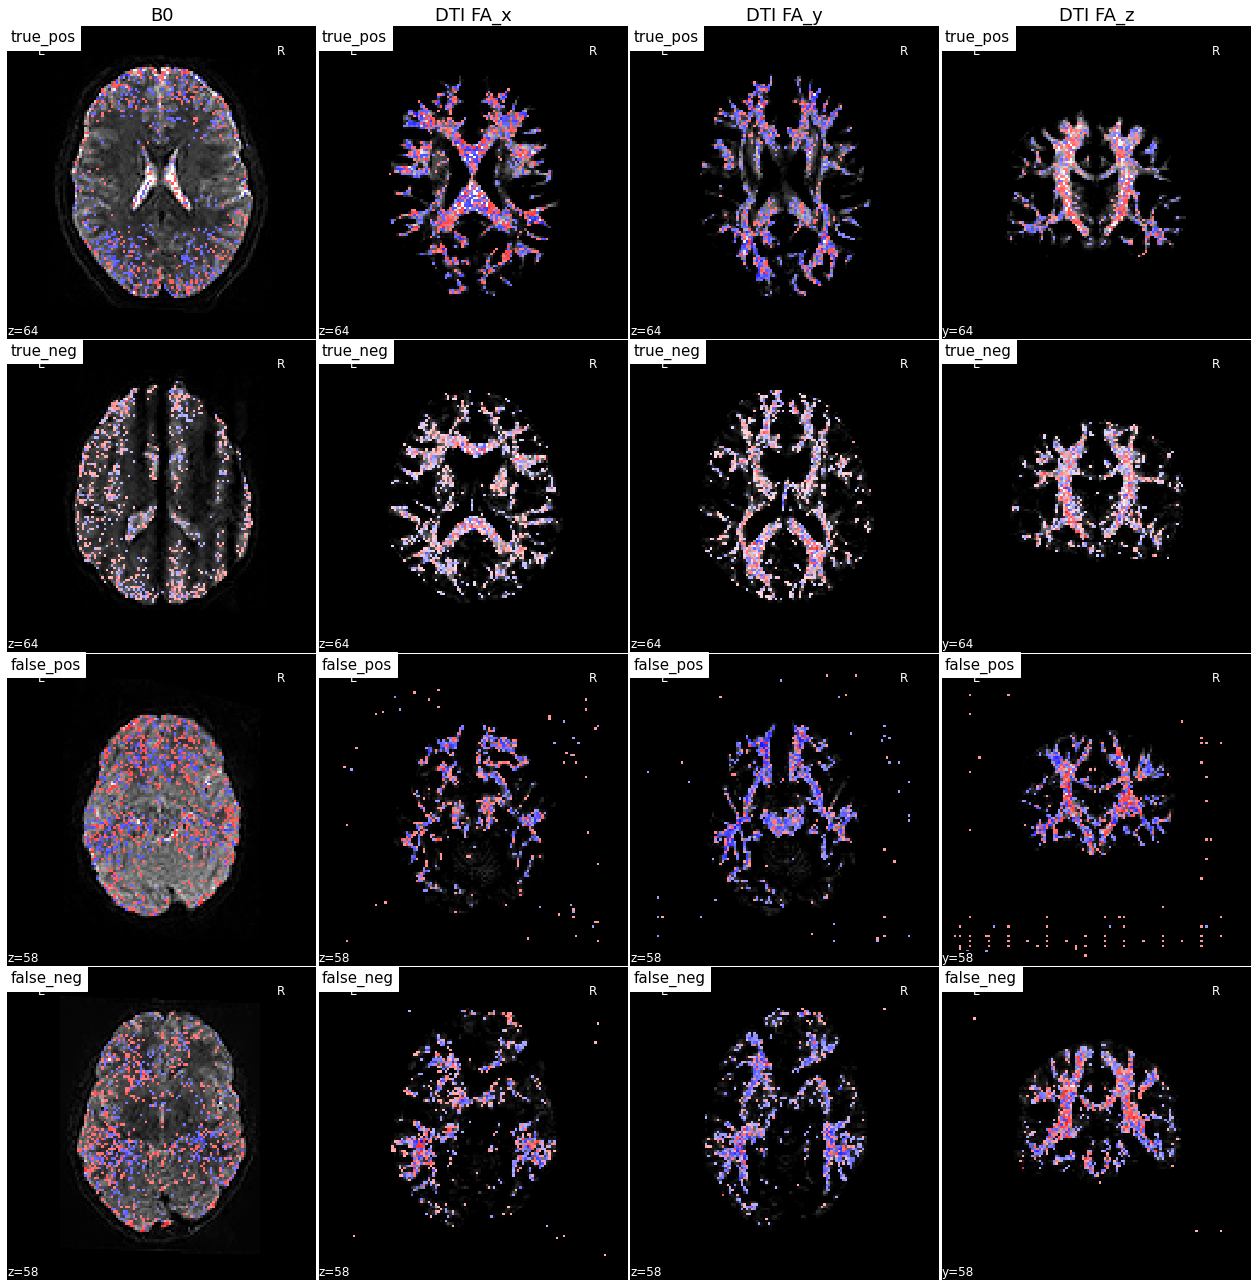

In [106]:
fig, axes = plt.subplots(4, 4, figsize=(18, 18))
fig.tight_layout(h_pad=-2, w_pad=-2.8)

subject_indices = {
    "true_pos": 1,
    "true_neg": 1,
    "false_pos": 0,
    "false_neg": 0,
}

cut_coord = {
    "true_pos": [64],
    "true_neg": [64],
    "false_pos": [58],
    "false_neg": [58],
}

channels = {
    "b0": "B0",
    "x": "DTI FA_x",
    "y": "DTI FA_y",
    "z": "DTI FA_z",
}

for conf_class, ax_row in zip(confusion_classes, axes):
    for channel, ax in zip(channels.keys(), ax_row):
        _ = plot_attribution(
            attribution_maps,
            bg_volumes,
            conf_class=conf_class,
            channel=channel,
            display_mode="y" if channel == "z" else "z",
            threshold=98,
            arcsinh_transform=True,
            cmap="bwr_r",
            axes=ax,
            subject_idx=subject_indices[conf_class],
            cut_coords=cut_coord[conf_class],
            colorbar=False,
            title=conf_class,
            annotate=True,
            dim=-0.5,
        )
    
for ax, label in zip(axes[0], channels.values()):
    ax.set_title(label, fontsize=18)
    
for ax, label in zip(axes.T[0], confusion_classes):
    ax.set_ylabel(label, fontsize=18)